In [72]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from fuzzywuzzy import process

%matplotlib inline
sns.set(color_codes=True)

In [73]:
df = pd.read_csv('../data/claims_sample_data.csv')
print(df.dtypes)
print(df.info)

MONTH                int64
SERVICE_CATEGORY    object
CLAIM_SPECIALTY     object
PAYER               object
PAID_AMOUNT          int64
dtype: object
<bound method DataFrame.info of         MONTH SERVICE_CATEGORY     CLAIM_SPECIALTY    PAYER  PAID_AMOUNT
0      201801     AncillaryFFS                 NaN  Payer F         4281
1      201801     AncillaryFFS                 NaN  Payer H         2221
2      201801     AncillaryFFS                 NaN  Payer O         3937
3      201801     AncillaryFFS                 NaN  Payer W          268
4      201801     AncillaryFFS                 ACH  Payer W          151
...       ...              ...                 ...      ...          ...
52147  202007   SpecialistsFFS  RADIATION ONCOLOGY  Payer F          869
52148  202007   SpecialistsFFS    REGISTERED NURSE  Payer H           99
52149  202007   SpecialistsFFS        RHEUMATOLOGY  Payer F          536
52150  202007   SpecialistsFFS    SPECIAL SERVICES  Payer H         1064
52151  202007   

In [74]:
print(df['PAID_AMOUNT'].describe())

count    5.215200e+04
mean     3.708707e+03
std      3.449842e+04
min     -4.223000e+04
25%      1.940000e+02
50%      5.860000e+02
75%      1.465000e+03
max      2.268611e+06
Name: PAID_AMOUNT, dtype: float64


## Чистка данных

In [75]:
# Поиск дублей
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows:", duplicate_rows_df.shape)

number of duplicate rows: (0, 5)


In [76]:
df.isnull().sum()

MONTH                 0
SERVICE_CATEGORY      0
CLAIM_SPECIALTY     251
PAYER                 0
PAID_AMOUNT           0
dtype: int64

Нулевые значения платежей посчитаем незначащими.

In [77]:
df3 = df.loc[df['PAID_AMOUNT'] == 0]
df3.shape

(3847, 5)

In [78]:
MATCH_RATIO = 94
MIN_WORD_LEN = 6
# поиск сокращений
def find_substrings(vals: set) -> dict:
    vals = sorted(vals)
    match_map = {}
    for index, val in enumerate(vals[:-1]):
        for next_index in range(index + 1, len(vals)):
            if vals[next_index].find(val, 0, len(val)) < 0:
                break
            if vals[next_index][len(val)] == ' ':
                continue
            if match_map.get(val) and len(match_map.get(val)) <= len(vals[next_index]):
                continue
            match_map[val] = vals[next_index]
    for val in list(set(match_map.keys()) & set(match_map.values())):
        match_map.pop(val)
    return match_map

# поиск схожих выражений
def match_rows(vals: set) -> dict:
    results = {}
    vals = sorted(list(filter(lambda x: len(x) >= MIN_WORD_LEN, vals)))
    for val in vals:
        res = process.extract(val, vals, limit=4)
        results[val] = res[1:]
    substr_map = {}
    for val in vals:
        if val in substr_map.keys():
            continue
        similar_combinations = results.get(val, [])
        for similar_comb, ratio in similar_combinations:
            if ratio <= MATCH_RATIO:
                continue
            substr_map[similar_comb] = val
    return substr_map


In [79]:
df = df.loc[df['PAID_AMOUNT'] != 0]
df['MONTH_DT'] = pd.to_datetime(df['MONTH'], format='%Y%m', errors='coerce').dt.date
df = df.dropna()

# Приведем значения CLAIM_SPECIALTY к более стандартной форме, избавимся от дублей и некоторых сокращений
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].str.upper().str.strip()
for item in ['(', ')', '-', '/', '\\', ',', 'AND', '&', '\'S', '.']:
    df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].str.replace(item, ' ', regex=True)
df['CLAIM_SPECIALTY_SPLIT'] = df['CLAIM_SPECIALTY'].apply(lambda x: str(x).split())
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY_SPLIT'].apply(lambda x: ' '.join(sorted(set(x), key=x.index)))
del df['CLAIM_SPECIALTY_SPLIT']
df['SERVICE_CATEGORY'] = df['SERVICE_CATEGORY'].replace('SpecialistFFS', 'SpecialistsFFS')
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].replace({'SURGICAL': 'SURGERY', 'ORTHOPAEDIC': 'ORTHOPEDIC'}, regex=True)
m_map = match_rows(set(df['CLAIM_SPECIALTY'].tolist()))
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].replace(m_map)
s_map = find_substrings(set(df['CLAIM_SPECIALTY'].tolist()))
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].replace(s_map)


Отрицательные значения платежей считать выбросами\ошибками?
Распределены они не равномерно, встречаются только у 2х категорий сервисов, при этом уводят сумму платежей за весь период по отделению PCPEncounter в отрицательное значение.

In [80]:
df3 = df.loc[df['PAID_AMOUNT'] < 0]
df_negative_p_sc = df3[['SERVICE_CATEGORY', 'PAID_AMOUNT']].groupby('SERVICE_CATEGORY').count()
print(df_negative_p_sc)
df_negative_p_p = df3[['PAYER', 'PAID_AMOUNT']].groupby('PAYER').count()
print(df_negative_p_p)
df2 = df[['SERVICE_CATEGORY', 'PAID_AMOUNT']].groupby('SERVICE_CATEGORY').sum().sort_values(by=['PAID_AMOUNT'])
print(df2)

                  PAID_AMOUNT
SERVICE_CATEGORY             
AncillaryFFS              236
PCPEncounter               82
          PAID_AMOUNT
PAYER                
Payer B             6
Payer CA           83
Payer CO            1
Payer H             3
Payer UN          223
Payer W             2
                    PAID_AMOUNT
SERVICE_CATEGORY               
PCPEncounter             -35888
PCPFFS                  3684644
ASCServices             5182525
SNFServices             8147959
ERServices             11742674
AncillaryFFS           19009539
OutpatientServices     22913612
SpecialistsFFS         34294315
InpatientServices      87799436


In [81]:
# Отрицательные значения тоже исключим
df = df.loc[df['PAID_AMOUNT'] > 0]
df.shape

(47727, 6)

## Разброс платежей, в том числе в группах по отделениям и страховым компаниям

<Axes: xlabel='PAID_AMOUNT'>

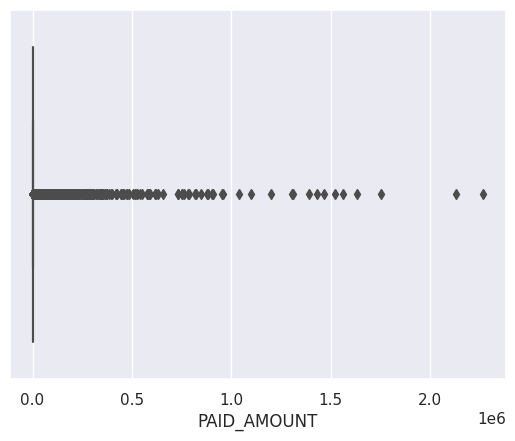

In [82]:
sns.boxplot(x=df['PAID_AMOUNT'])

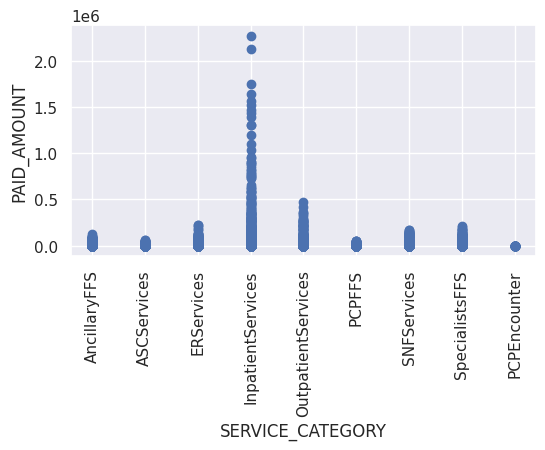

In [83]:
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(df['SERVICE_CATEGORY'], df['PAID_AMOUNT'])
ax.set_xlabel('SERVICE_CATEGORY')
ax.set_ylabel('PAID_AMOUNT')
plt.xticks(rotation=90)
plt.show()

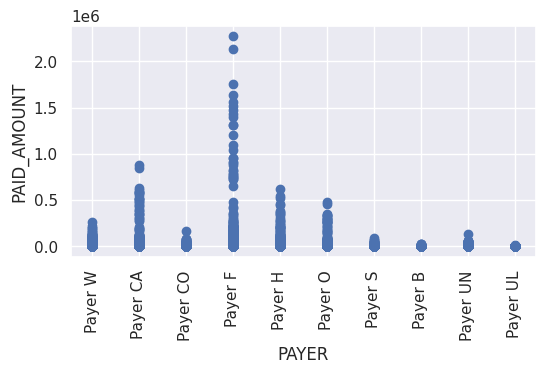

In [84]:
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(df['PAYER'], df['PAID_AMOUNT'])
ax.set_xlabel('PAYER')
ax.set_ylabel('PAID_AMOUNT')
plt.xticks(rotation=90)
plt.show()

Считать ли выбросами платежи, превышающие 1,5-2млн? Судя по графикам, это редкие значения, но оказывающие большое влияние на итоговые суммы. Думаю, при анализе затрат исключать их из выборки будет неверным.

## Суммы платежей и средняя величина в разрезах за весь период

                    PAID_AMOUNT
SERVICE_CATEGORY               
PCPEncounter              18353
PCPFFS                  3684644
ASCServices             5182525
SNFServices             8147959
ERServices             11742674
AncillaryFFS           19296630
OutpatientServices     22913612
SpecialistsFFS         34294315
InpatientServices      87799436


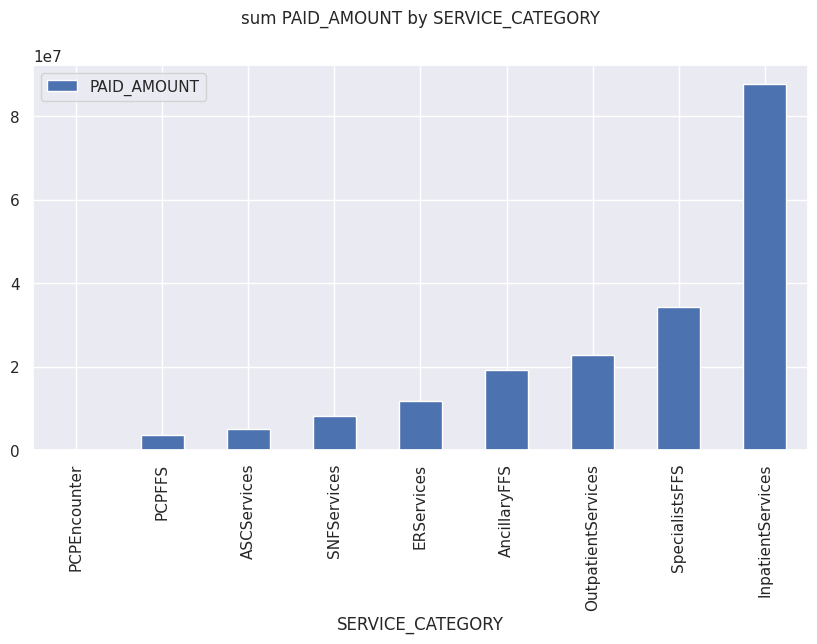

In [85]:
df2 = df[['SERVICE_CATEGORY', 'PAID_AMOUNT']].groupby('SERVICE_CATEGORY').sum().sort_values(by=['PAID_AMOUNT'])
df2.plot(kind='bar', figsize=(10,5))
plt.title("sum PAID_AMOUNT by SERVICE_CATEGORY")
print(df2)

Максимальные затраты приходятся на категории InpatientServices, SpecialistsFFS, OutpatientServices.
Минимальные - на PCPEncounter, PCPFFS.

                    PAID_AMOUNT
SERVICE_CATEGORY               
PCPEncounter         426.813953
ASCServices         2033.958006
AncillaryFFS        2385.244747
SpecialistsFFS      2564.060935
PCPFFS              2695.423555
OutpatientServices  3137.561550
ERServices          3361.773261
SNFServices         3519.636717
InpatientServices   9550.683781


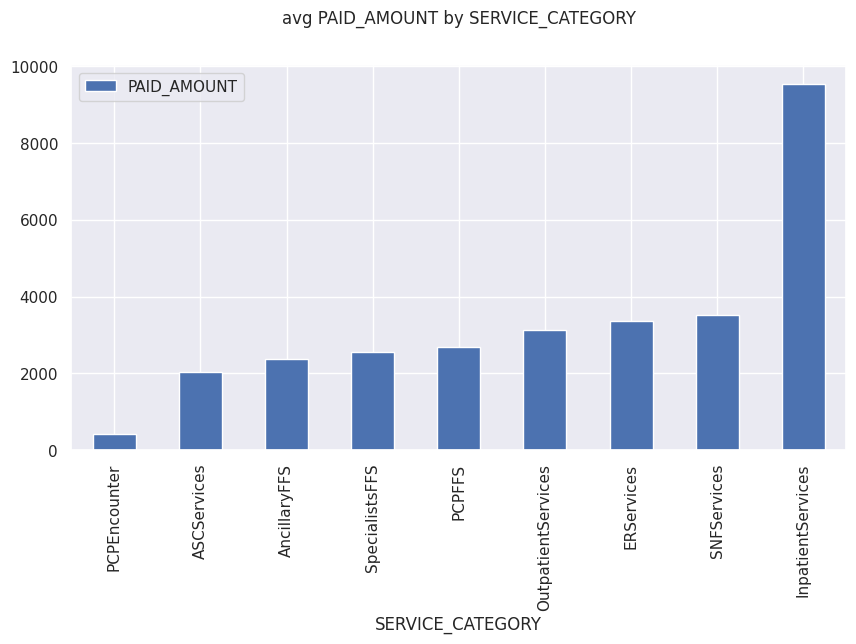

In [86]:
df2 = df[['SERVICE_CATEGORY', 'PAID_AMOUNT']].groupby('SERVICE_CATEGORY').mean().sort_values(by=['PAID_AMOUNT'])
df2.plot(kind='bar', figsize=(10,5))
plt.title("avg PAID_AMOUNT by SERVICE_CATEGORY")
print(df2)

По средней величине платежа в топе уже InpatientServices, SNFServices, ERServices

          PAID_AMOUNT
PAYER                
Payer UL       310027
Payer B       2409074
Payer S       3784945
Payer CO      5068766
Payer UN      6272206
Payer W      12180796
Payer O      21261058
Payer H      21768803
Payer CA     33690508
Payer F      86333965


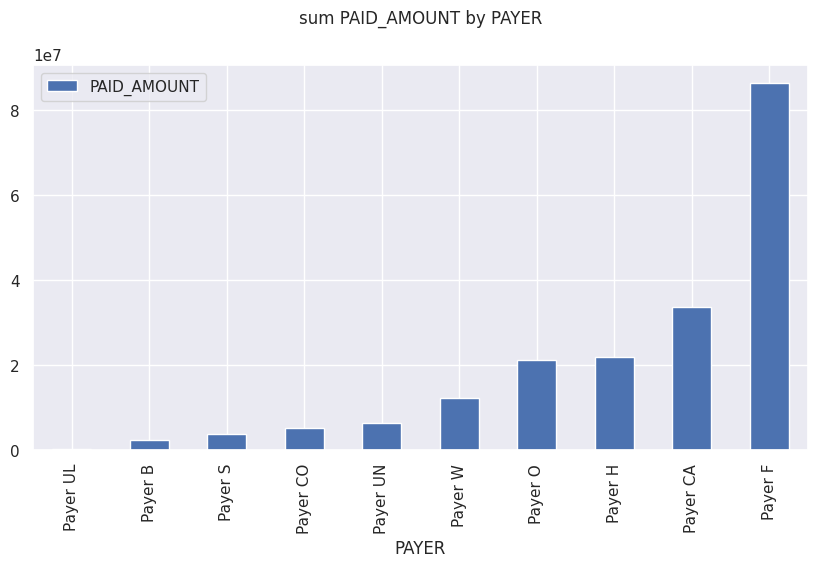

In [87]:
df2 = df[['PAYER', 'PAID_AMOUNT']].groupby('PAYER').sum().sort_values(by=['PAID_AMOUNT'])
df2.plot(kind='bar', figsize=(10,5))
plt.title("sum PAID_AMOUNT by PAYER")
print(df2)

Максимальные затраты приходятся на страховые компании F, CA, H, O.
Минимальные - на UL, B, S.

          PAID_AMOUNT
PAYER                
Payer UL   551.649466
Payer B    751.426700
Payer S    976.256126
Payer UN  1280.564720
Payer CO  1380.007079
Payer W   1846.974375
Payer O   3488.851001
Payer CA  4291.237804
Payer H   9739.956600
Payer F   9882.550939


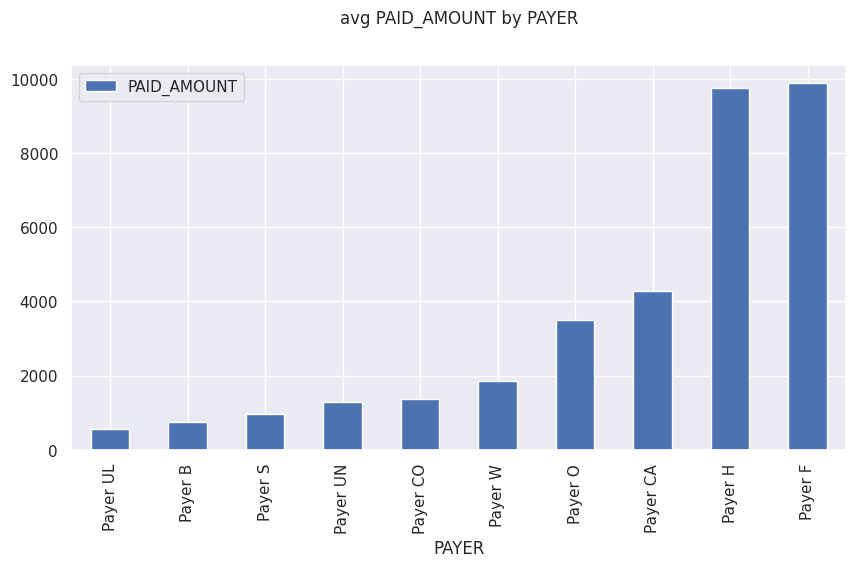

In [88]:
df2 = df[['PAYER', 'PAID_AMOUNT']].groupby('PAYER').mean().sort_values(by=['PAID_AMOUNT'])
df2.plot(kind='bar', figsize=(10,5))
plt.title("avg PAID_AMOUNT by PAYER")
print(df2)


По средней величине платежа в разрезе страхователей аналогично.

Топ-10 самых затратных услуг
                                          PAID_AMOUNT
CLAIM_SPECIALTY                                      
INP                                          41412982
HOSPITAL                                     40113868
OUTPATIENT MENTAL HEALTH CLINICIAN GROUP     14025004
HEMATOLOGY ONCOLOGY                           6111451
INTERNAL MEDICINE                             4860165
MEDICAL DOCTOR                                4555419
CARDIOLOGY                                    4409537
SNF                                           4248390
RADIOLOGY                                     3207034
SKILLED NURSING FACILITY                      2719775


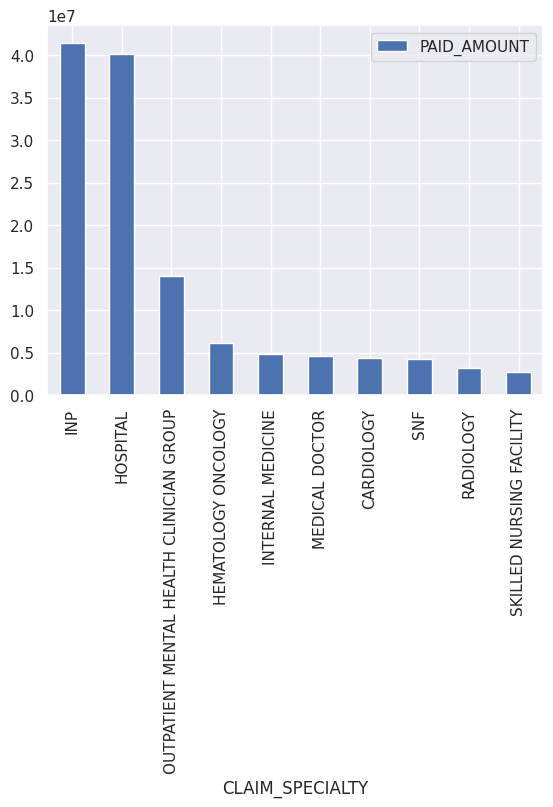

In [89]:
df2 = df[['CLAIM_SPECIALTY', 'PAID_AMOUNT']].groupby('CLAIM_SPECIALTY').sum().sort_values(by=['PAID_AMOUNT'], ascending=False)
print('Топ-10 самых затратных услуг')
print(df2.head(10))
df2[:10].plot.bar()
plt.show()


Наверняка, не все названия сервисов оказались унифицированы, но категории INP и HOSPITAL все равно можно назвать самыми затратными.

## Количество платежей в разрезах

In [90]:
def group_plot(dff, col, title, hue=None):
    sns.set_style('darkgrid')
    temp = pd.Series(data=hue)
    figure, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    figure.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.title(title)
    sns.countplot(data=dff, x=col, order=dff[col].value_counts().index, hue=hue, palette='bright')
    plt.show()

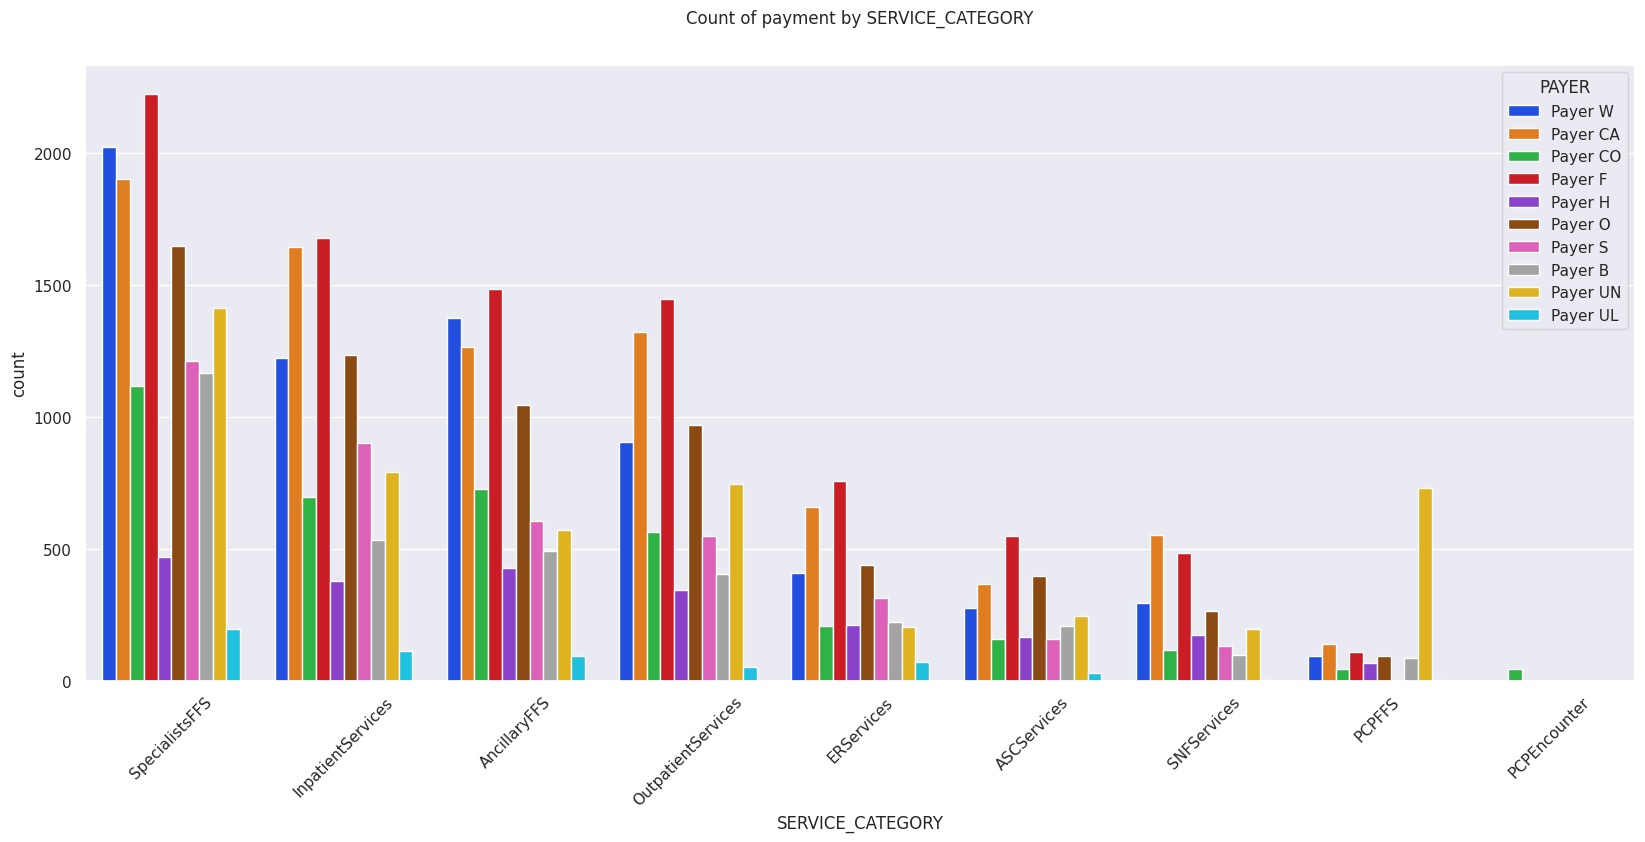

In [91]:
group_plot(df, col='SERVICE_CATEGORY', title='Count of payment by SERVICE_CATEGORY', hue='PAYER')

Здесь можно увидеть количество платежей в разрезе категорий сервисов, а также вклад каждой страховой компании.
Выделяется, что в категории PCPFFS заметно бОльшее число платежей производит Payer UN в сравнении с прочими.

## Графики по месяцам

### Попробуем отследить временные тренды в разрезе категорий сервисов

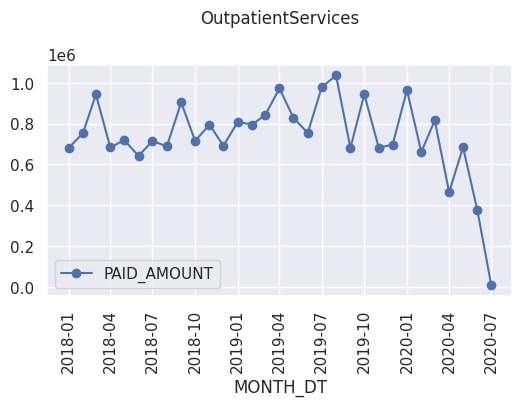

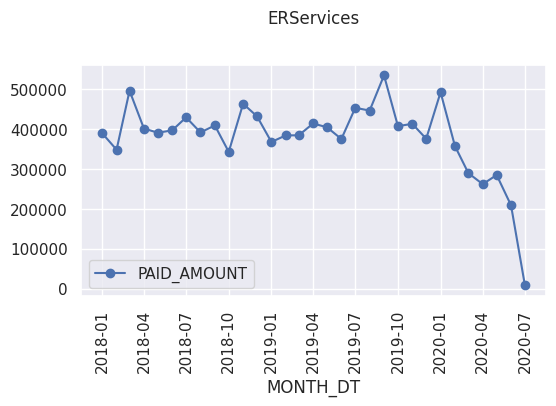

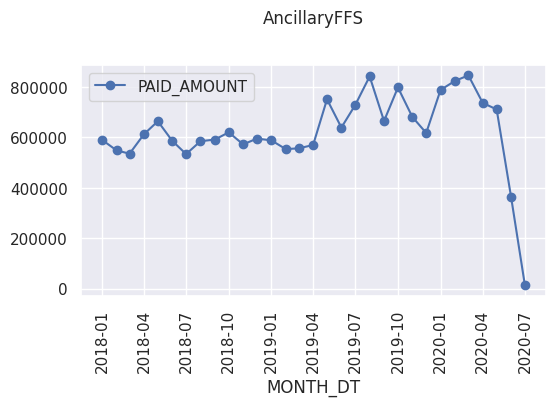

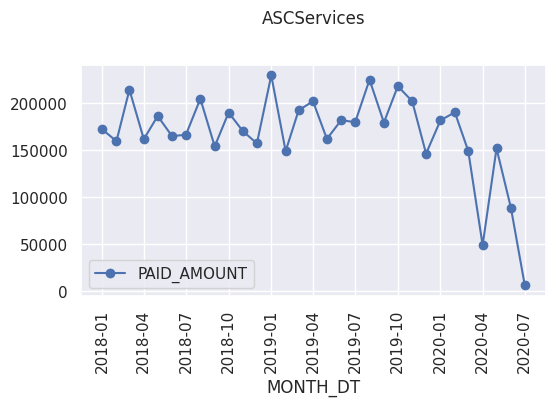

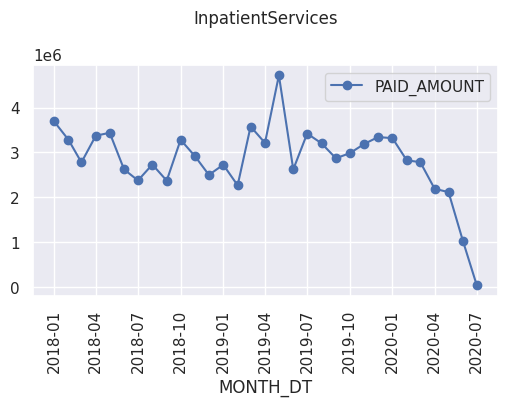

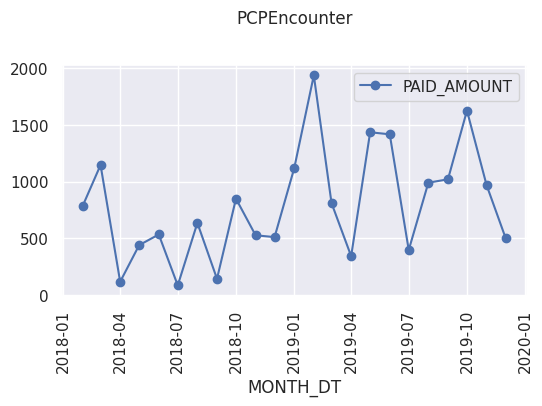

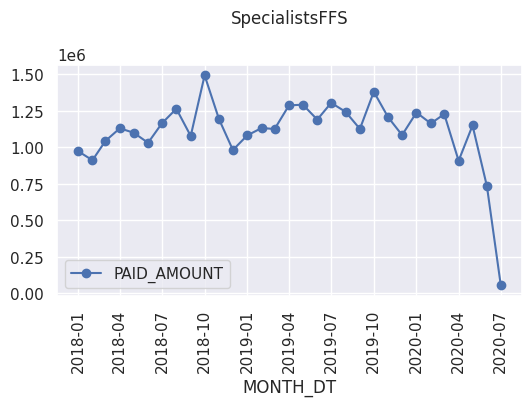

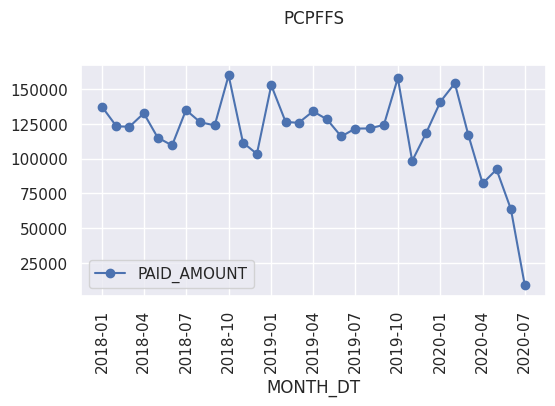

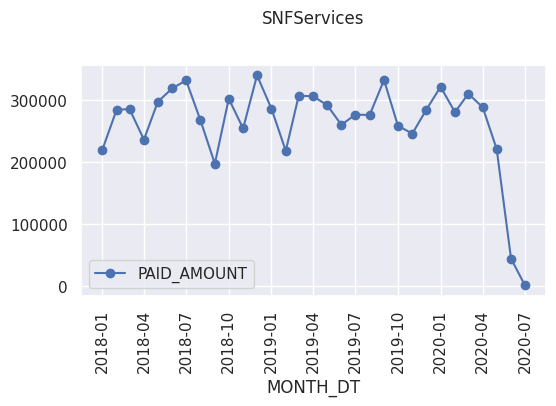

In [92]:
# Суммы платежей за месяц в разрезе SERVICE_CATEGORY
sc_list = set(df['SERVICE_CATEGORY'].to_list())
for sc in sc_list:
    df_part = df.loc[df['SERVICE_CATEGORY'] == sc]
    df_part_groped = df_part[['MONTH_DT', 'PAID_AMOUNT']].groupby('MONTH_DT').sum().reset_index()
    df_part_groped.plot(x='MONTH_DT', y='PAID_AMOUNT', rot=90, figsize=(6, 3), grid=True, marker='o', title=sc)

Заметно снижение суммарных затрат за месяц по многим категориям сервисов к концу периода, как и количество выплат.

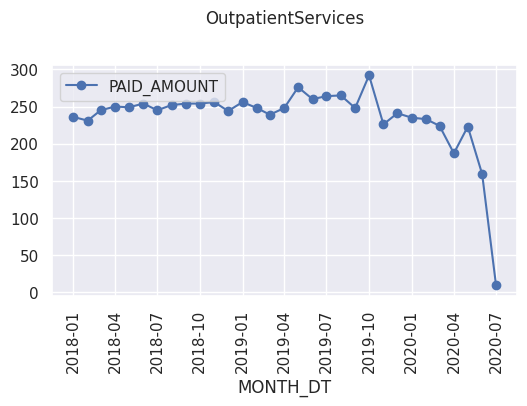

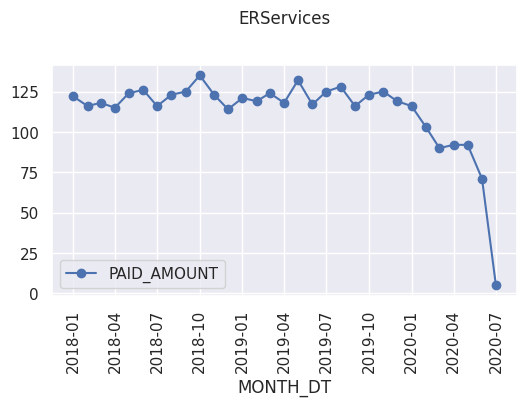

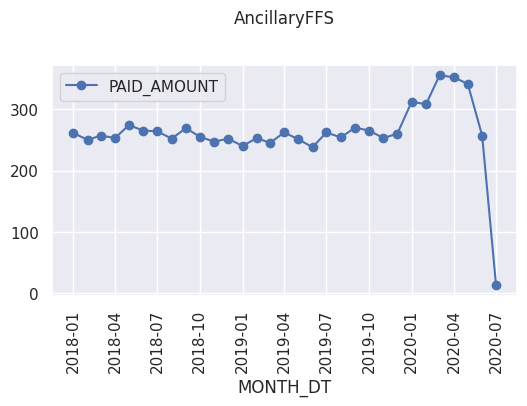

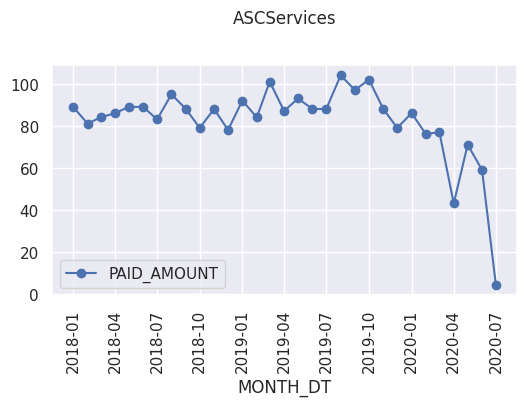

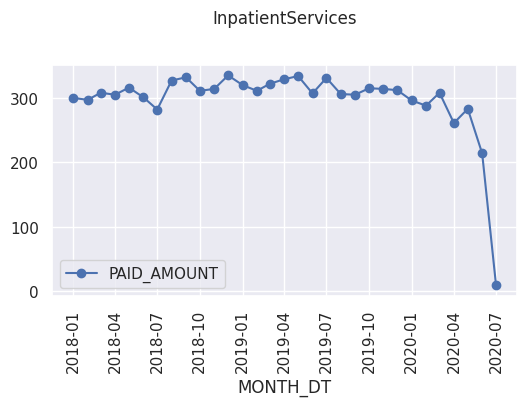

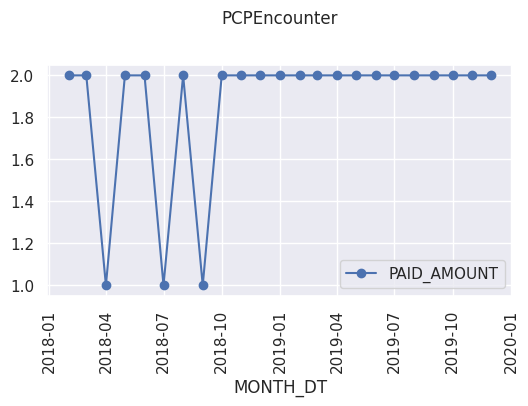

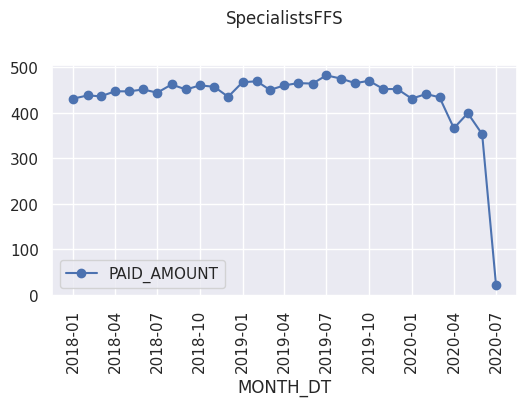

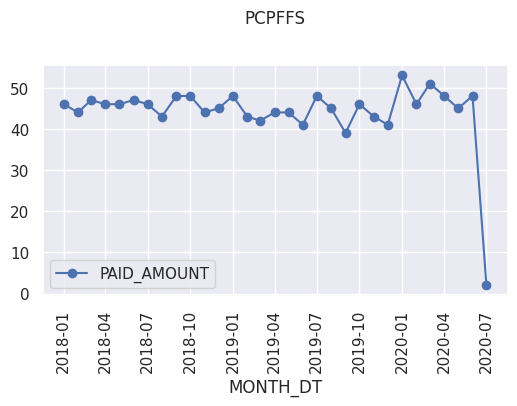

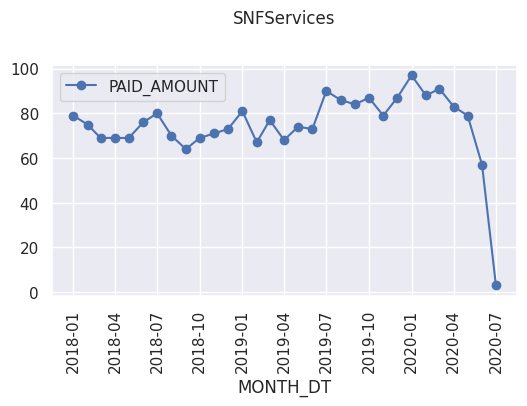

In [93]:
# Количество платежей за месяц в разрезе SERVICE_CATEGORY
sc_list = set(df['SERVICE_CATEGORY'].to_list())
for sc in sc_list:
    df_part = df.loc[df['SERVICE_CATEGORY'] == sc]
    df_part_groped = df_part[['MONTH_DT', 'PAID_AMOUNT']].groupby('MONTH_DT').count().reset_index()
    df_part_groped.plot(x='MONTH_DT', y='PAID_AMOUNT', rot=90, figsize=(6, 3), grid=True, marker='o', title=sc)

### Попробуем отследить временные тренды в разрезе страховых компаний

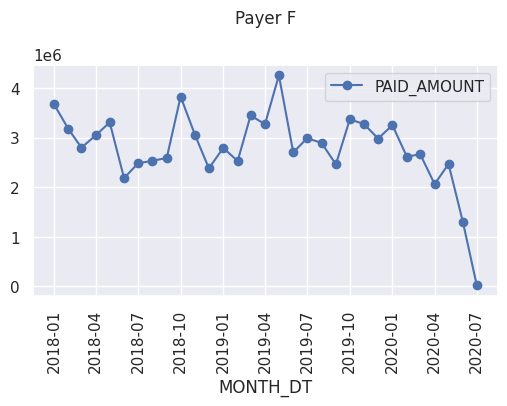

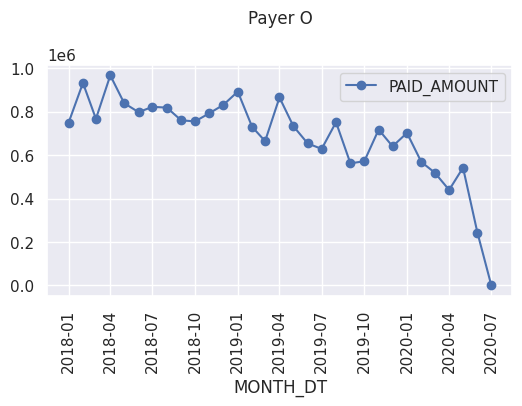

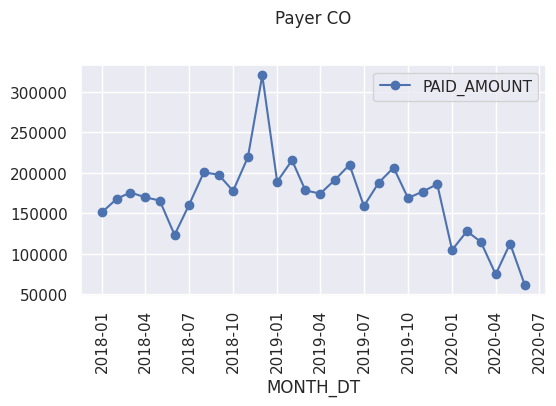

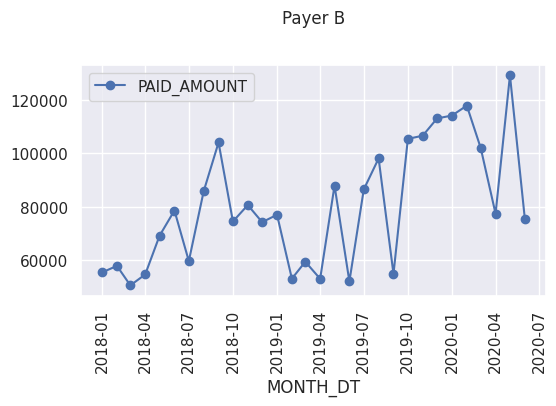

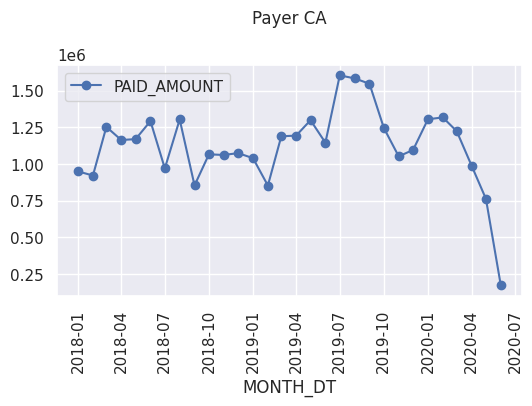

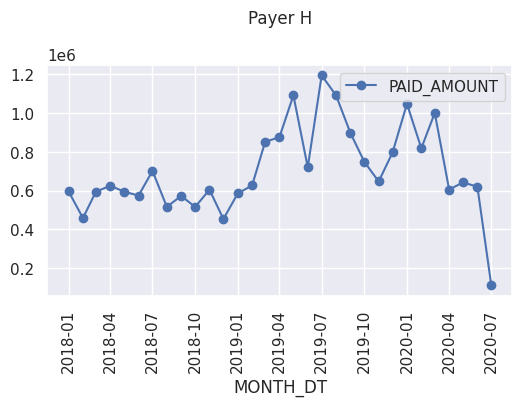

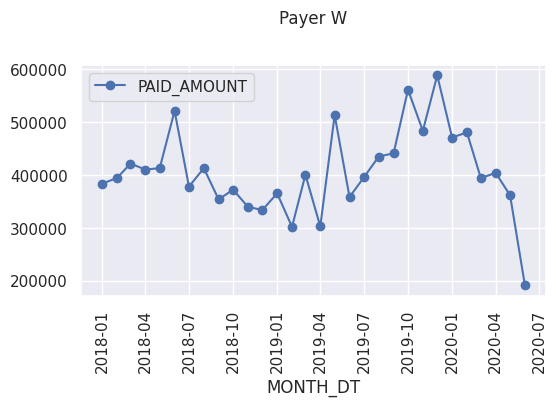

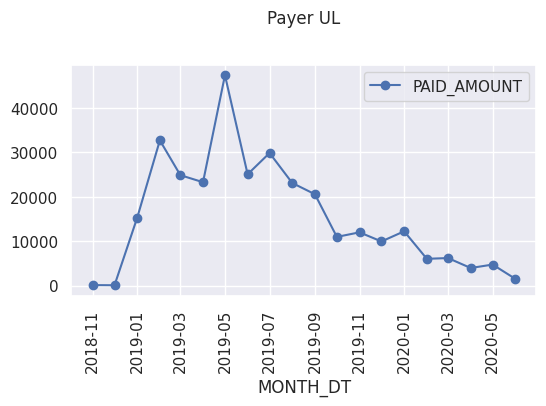

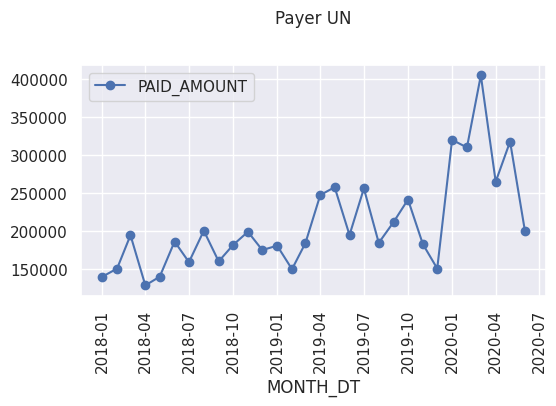

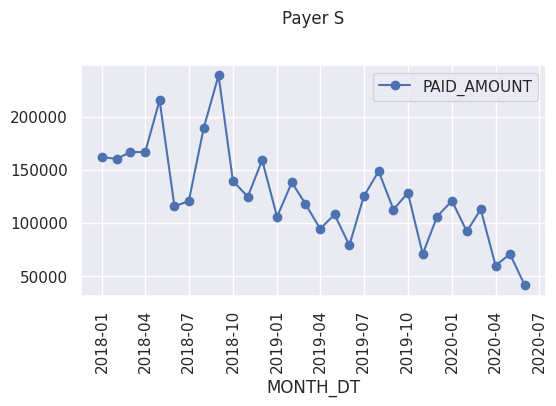

In [94]:
sc_list = set(df['PAYER'].to_list())
for sc in sc_list:
    df_part = df.loc[df['PAYER'] == sc]
    df_part_groped = df_part[['MONTH_DT', 'PAID_AMOUNT']].groupby('MONTH_DT').sum().reset_index()
    df_part_groped.plot(x='MONTH_DT', y='PAID_AMOUNT', rot=90, figsize=(6, 3), grid=True, marker='o', title=sc)

Заметно снижение затрат у страховых компаний S, O на протяжении всего периода, у других компаний (UL, CO) снижение наметилось с середины 2019 года.
У компании UN напротив наблюдается тенденция роста затрат. W, H - в конце 2019\начале 2020 преодолели пик.

### Попробуем отследить временные тренды в разрезе сервисов

Групп довольно много, поэтому сохраним графики в файлы.

In [246]:
# path = '../images/charts_by_specialty_sum'
# fig, ax = plt.subplots(figsize=(10,6))
# specialties = set(df['CLAIM_SPECIALTY'].to_list())
# for specialty in list(specialties):
#     df_part = df.loc[df['CLAIM_SPECIALTY'] == specialty]
#     df_part_sum = df_part[['MONTH_DT', 'PAID_AMOUNT']].groupby('MONTH_DT').sum()
#     df_part_sum = df_part_sum.reset_index()
#     ax.plot(df_part_sum['MONTH_DT'], df_part_sum['PAID_AMOUNT'])
#     ax.scatter(df_part_sum['MONTH_DT'], df_part_sum['PAID_AMOUNT'])
#     ax.set_xlabel('MONTH_DT')
#     ax.set_ylabel('PAID_AMOUNT')
#     plt.xticks(rotation=45)
#     plt.title(specialty)
#     figname = 'fig_{}.png'.format(specialty.replace('/', ' '))
#     dest = os.path.join(path, figname)
#     # plt.show()
#     plt.savefig(dest)  # write image to file
#     plt.cla()
# plt.close(fig)
# print('Done.')

Done.


In [95]:
GRAPH_LIMIT = 20
def show_graph(specialties):
    for sp_name in specialties[:GRAPH_LIMIT]:
        df_p = df.loc[df['CLAIM_SPECIALTY'] == sp_name]
        df_p_sum = df_p[['MONTH_DT', 'PAID_AMOUNT']].groupby('MONTH_DT').sum()
        df_p_sum = df_p_sum.reset_index()
        figure, ax = plt.subplots(figsize=(6,3))
        ax.plot(df_p_sum['MONTH_DT'], df_p_sum['PAID_AMOUNT'])
        ax.scatter(df_p_sum['MONTH_DT'], df_p_sum['PAID_AMOUNT'])
        plt.xticks(rotation=45)
        plt.title(sp_name)
        plt.show()

Выводы по этой части удобней смотреть на дашборде.

Можно заметить повышение затрат по сервису ADVANCED REGISTERED NURSE PRACTITIONER с середины 2019 года.


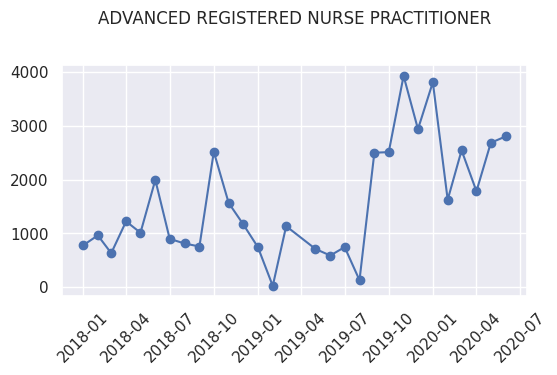

In [96]:
show_graph(['ADVANCED REGISTERED NURSE PRACTITIONER'])


Заметно снижение затрат по медицинской услуге AMBULANCE (и всех смежных), ANESTHESIOLOGY, HOSPITAL, EMERGENCY MEDICINE, INTERNAL MEDICINE
 c начала 2020 года.

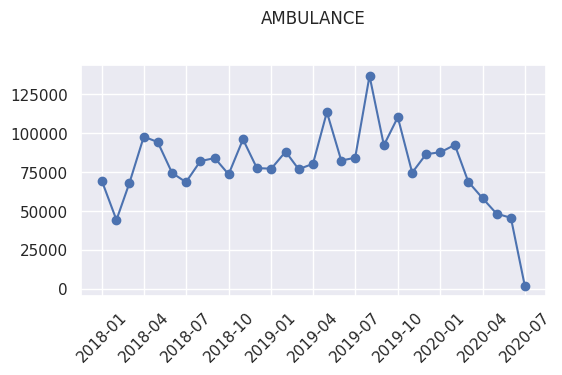

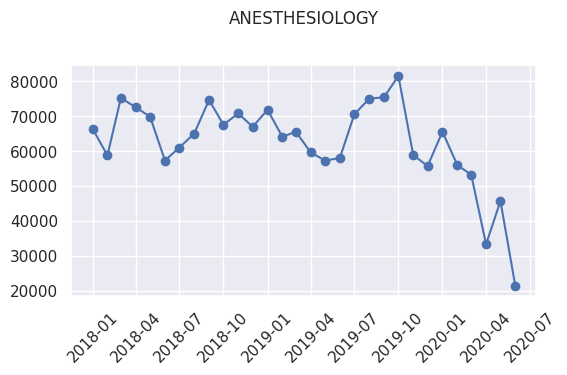

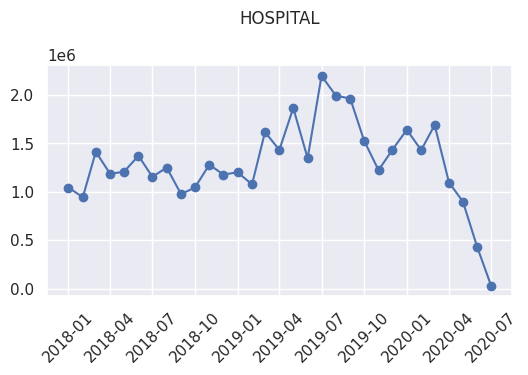

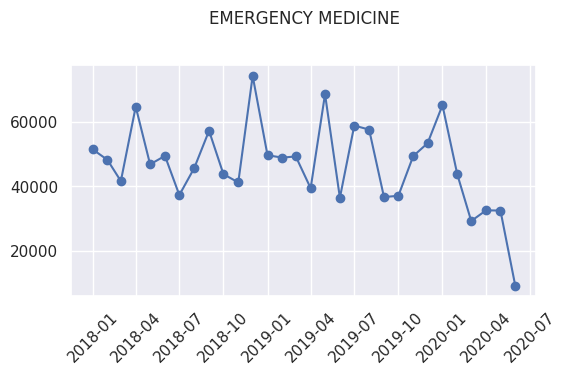

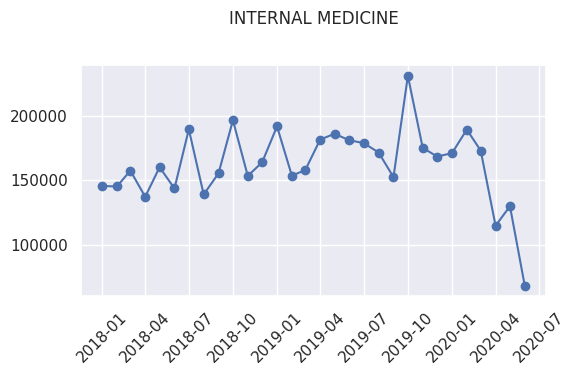

In [98]:
show_graph(['AMBULANCE', 'ANESTHESIOLOGY', 'HOSPITAL', 'EMERGENCY MEDICINE', 'INTERNAL MEDICINE'])


На всем периоде заметно стабильное повышение затрат в категории ONCOLOGY.


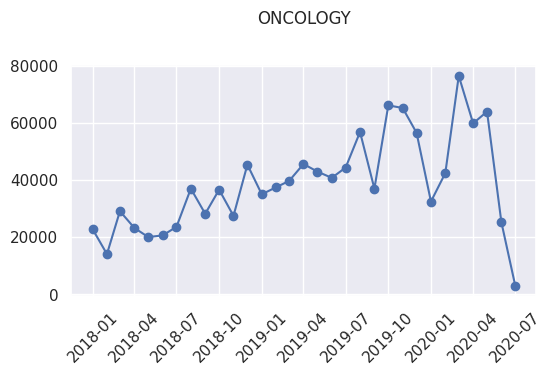

In [99]:
show_graph(['ONCOLOGY'])

На всем периоде наблюдается снижение затрат по FAMILY PRACTICE, FITNESS, GASTROENTEROLOGY, GERIATRICS, GYNECOLOGY, OPHTHALMOLOGY,
и для сервиса OUTPATIENT MENTAL HEALTH CLINICIAN GROUP с середины 2019 года.


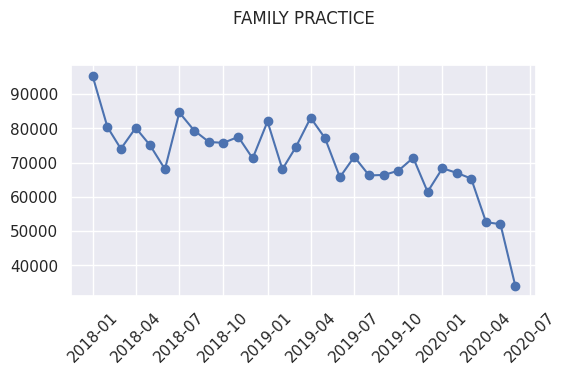

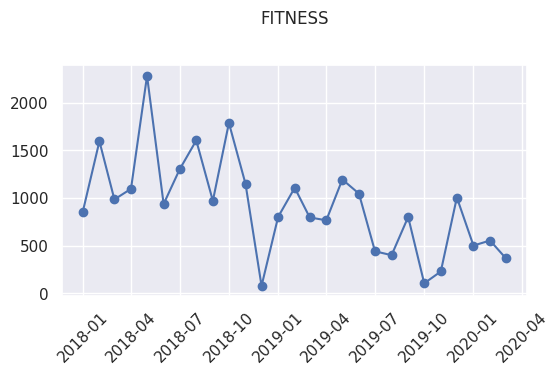

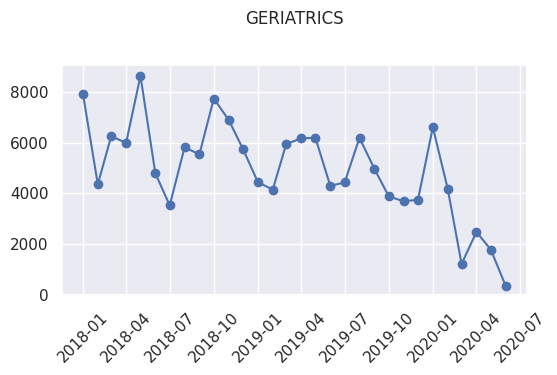

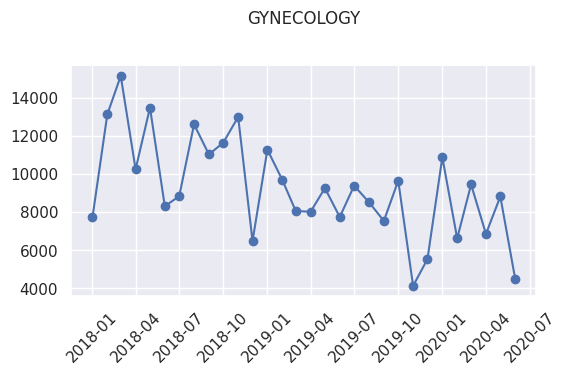

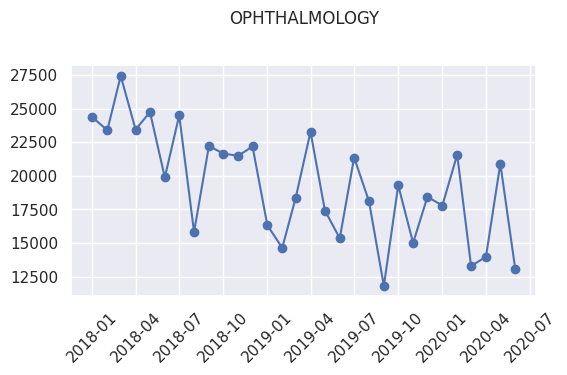

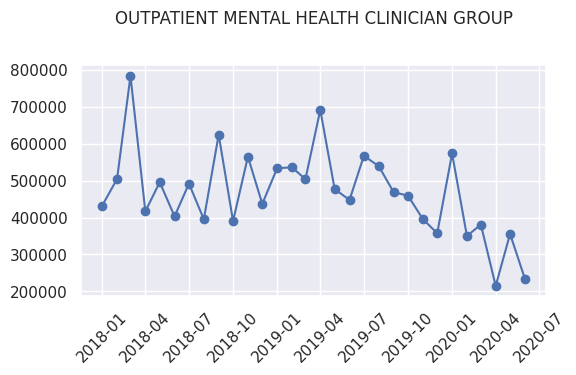

In [101]:
show_graph(['FAMILY PRACTICE', 'FITNESS', 'GERIATRICS', 'GYNECOLOGY', 'OPHTHALMOLOGY', 'OUTPATIENT MENTAL HEALTH CLINICIAN GROUP'])